# Data Modeling and Analysis 

## Introduction
This notebook operates on the CSV file final_merged_dataset.csv created by the notebook merge_preprocessed_data.ipynb

## Setup
We will import the neccessary libaries including **pandas**, **numpy**, **seaborn**, **matplotlib**, and **scikit-learn**.

The notebook offers functions to:
- **Load data** from a specified file path.
- **Visualize data** through various plots like histograms, density plots, box plots, and heatmaps. These visualizations aim to elucidate the data distribution, feature relationships, and the target variable's distribution.

## Machine Learning Analysis

### Classifiers 

We will use the following classifiers to train our model

1. **Logistic Regression**
2. **Random Forest**
3. **Gradient Boosting**
4. **Decision Tree**
5. **K-Nearest Neighbors (KNN)**

### Hyperparameter Grids

The following hyperparameters were used for each of the classifiers

- **Logistic Regression**:
  - `C`: [0.1, 1, 10]
  - `penalty`: ['l2']
  - `class_weight`: [None, 'balanced']

- **Random Forest**:
  - `n_estimators`: [100]
  - `max_depth`: [None, 10]
  - `min_samples_split`: [2, 5]
  - `min_samples_leaf`: [1, 2]

- **Gradient Boosting**:
  - `n_estimators`: [100]
  - `learning_rate`: [0.1]
  - `max_depth`: [5]

- **Decision Tree**:
  - `criterion`: ['gini']
  - `max_depth`: [10]
  - `min_samples_split`: [2, 5]
  - `min_samples_leaf`: [1, 2]

- **K-Nearest Neighbors**:
  - `n_neighbors`: [5]
  - `weights`: ['uniform']
  - `algorithm`: ['kd_tree']

### Stacked Ensemble
We will also use a stacked ensemble model to evaluate and train the data.



In [37]:
import os
import np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from prettytable import PrettyTable
from joblib import dump, load
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier


logging.basicConfig(level=logging.INFO)




## Constants

In [38]:

DATA_DIR = os.getcwd()
GRAPHS_DIR = os.path.join(DATA_DIR, 'graphs')
MERGED_DATA_FILEPATH = os.path.join(DATA_DIR, "final_merged_data.csv")



## Classifiers

In [39]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

param_grids = {
        'Logistic Regression': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'class_weight': [None, 'balanced']
        },
        'Random Forest': {
            'n_estimators': [100],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'Gradient Boosting': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [5]
        },
        'Decision Tree': {
            'criterion': ['gini'],
            'max_depth': [10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'K-Nearest Neighbors': {
            'n_neighbors': [5],
            'weights': ['uniform'],
            'algorithm': ['kd_tree']
        }
    }




### Function: load_data

In [40]:
def load_data(filepath):
    """Load dataset from a specified filepath."""
    return pd.read_csv(filepath)


### Function: visualize_data

In [41]:
def visualize_data(X, y):
    """Visualize the data distribution, correlations, and target distribution."""

    # Create graphs directory if it doesn't exist
    if not os.path.exists(GRAPHS_DIR):
        os.makedirs(GRAPHS_DIR)

    #Histogram for each numeric feature
    X.hist(bins=30, figsize=(10, 5))
    plt.suptitle("Histogram for each numeric feature")
    plt.savefig(os.path.join(GRAPHS_DIR, "feature_histograms.png"))
    plt.show()

    # Density Plots for numeric features
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.kdeplot(X['Activity Value'], ax=ax[0], fill=True)
    ax[0].set_title('Density Plot of Activity Value')
    sns.kdeplot(X['Heart Rate'], ax=ax[1], fill=True)
    ax[1].set_title('Density Plot of Heart Rate')
    plt.tight_layout()
    plt.savefig(os.path.join(GRAPHS_DIR, "feature_density_plots.png"))
    plt.show()

    # Box plot for each numeric feature
    plt.figure(figsize=(10, 5))
    X.boxplot()
    plt.title("Box plot for each numeric feature")
    plt.savefig(os.path.join(GRAPHS_DIR, "feature_boxplots.png"))
    plt.show()

    # Correlation heatmap
    correlation_matrix = X.corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
    plt.title("Correlation heatmap")
    plt.savefig(os.path.join(GRAPHS_DIR, "correlation_heatmap.png"))
    plt.show()

    # Pie Chart for target variable 'Stage Value'
    labels = y.value_counts().index
    sizes = y.value_counts().values
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Stage Value')
    plt.savefig(os.path.join(GRAPHS_DIR, "stage_value_pie_chart.png"))
    plt.show()

    # Violin Plots
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.violinplot(x=y, y=X['Activity Value'], ax=ax[0])
    ax[0].set_title('Activity Value by Stage Value')
    sns.violinplot(x=y, y=X['Heart Rate'], ax=ax[1])
    ax[1].set_title('Heart Rate by Stage Value')
    plt.tight_layout()
    plt.savefig(os.path.join(GRAPHS_DIR, "violin_plots.png"))
    plt.show()

    # Feature distributions with respect to the target
    numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=y, y=X[feature])
        plt.title(f"{feature} distribution with respect to the target")
        plt.savefig(os.path.join(GRAPHS_DIR, f"{feature}_target_distribution.png"))
        plt.show()

### Function: train_and_evaluate_classifiers

In [42]:
def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test):
    """Train, tune, and evaluate multiple classifiers."""
    
    # Hyperparameter grids and classifier instances

    base_classifiers = list(classifiers.items())
    meta_classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifiers['Stacked Ensemble'] = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)


    results = {}
    for name, clf in classifiers.items():
        results[name] = {}
        model_filename = os.path.join(DATA_DIR, f"{name.replace(' ', '_')}.joblib")
        
        # Check if model exists
        if os.path.exists(model_filename):
            data_loaded = load(model_filename)
            clf = data_loaded['model']
            classifiers[name] = clf
            classifiers[name] = clf
            results[name]['Best Hyperparameters'] = data_loaded.get('best_params', 'N/A')
        else:
            if name in param_grids:  # Check if hyperparameters are defined for this classifier
                grid = GridSearchCV(clf, param_grids[name], cv=5, n_jobs=-1)
                grid.fit(X_train, y_train)
                # Train the classifier with the best parameters
                clf.set_params(**grid.best_params_)
                best_params = grid.best_params_
                hyperparams_str = ', '.join([f"{param}={value}" for param, value in best_params.items()])
                results[name]['Best Hyperparameters'] = hyperparams_str


            clf.fit(X_train, y_train)

            # Save the model to disk
            data_to_save = {
                'model': clf,
                'best_params': hyperparams_str
            }
            dump(data_to_save, model_filename)

        # Predict on the test set
        y_pred = clf.predict(X_test)

        # Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)

        # Store the results
        results[name]['Accuracy'] = accuracy
        results[name]['Classification Report'] = classification_rep


    return results




### Function: plot_results

In [43]:
def plot_results(X_test, y_test, classifiers):
    """Plot ROC and PR curves for all classifiers."""
    
    # Initialize figures for ROC and PR curves
    plt.figure(figsize=(12, 6))

    for name, clf in classifiers.items():
        # Get the probability of the positive class
        y_probs = clf.predict_proba(X_test)[:, 1]
    
        # ROC curve values
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(GRAPHS_DIR, "roc_curves.png"))
    plt.show()

    # Plot Precision-Recall curves
    plt.figure(figsize=(12, 6))
    for name, clf in classifiers.items():
        precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
        plt.plot(recall, precision, label=f'{name} (AUC = {average_precision_score(y_test, clf.predict_proba(X_test)[:, 1]):.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(GRAPHS_DIR, "precision_recall_curves.png"))
    plt.show()


## Main Analysis

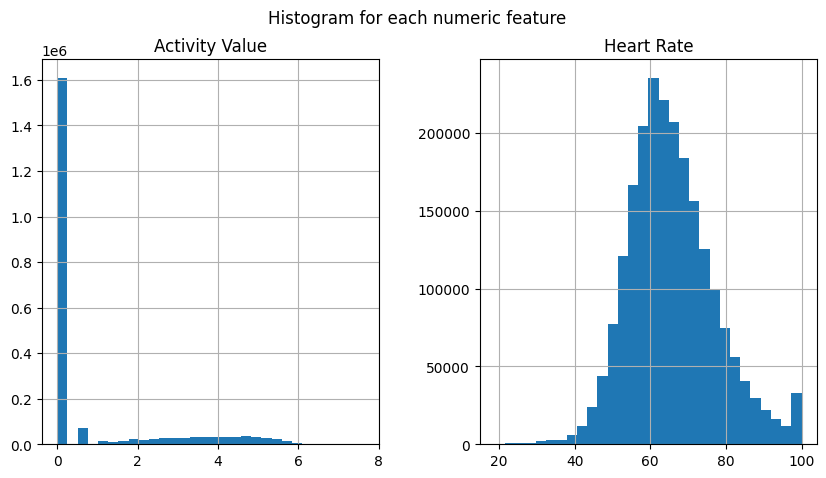

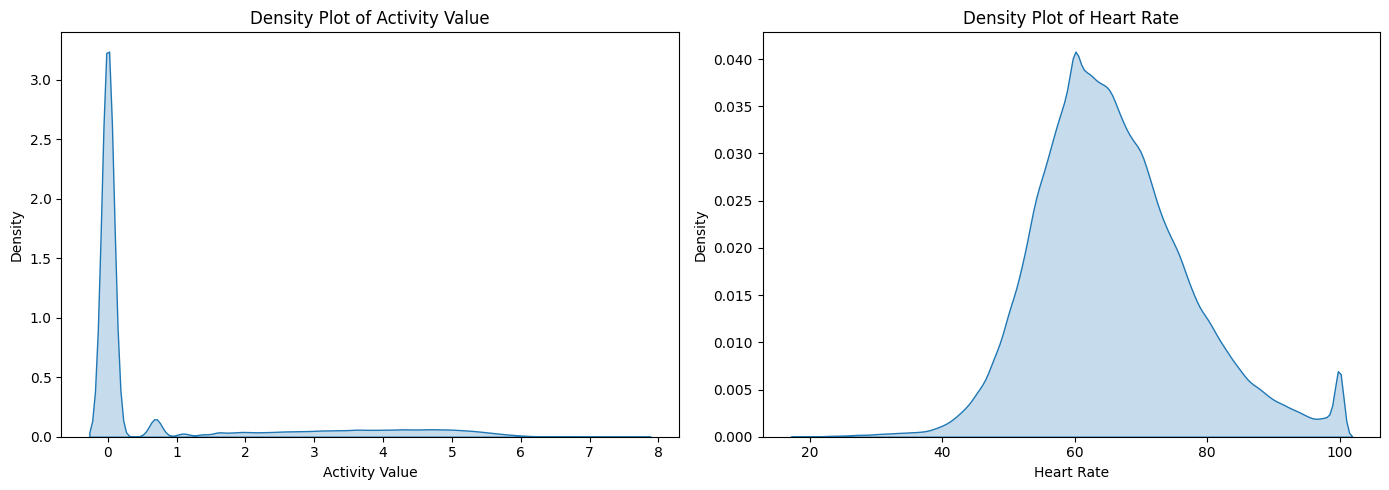

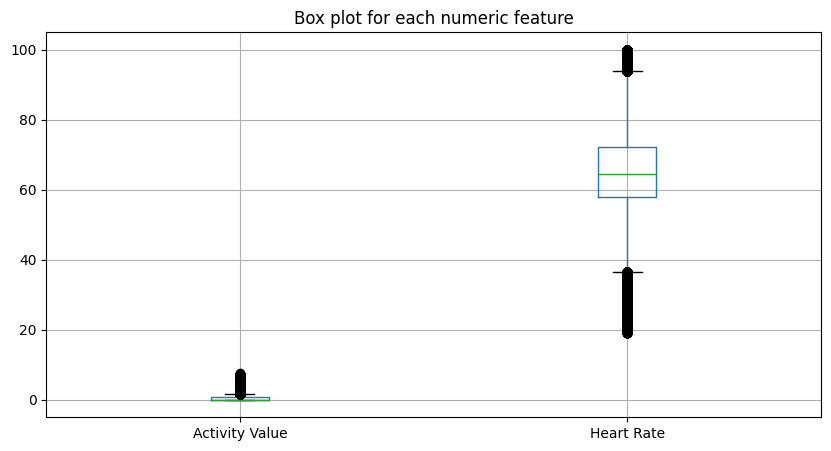

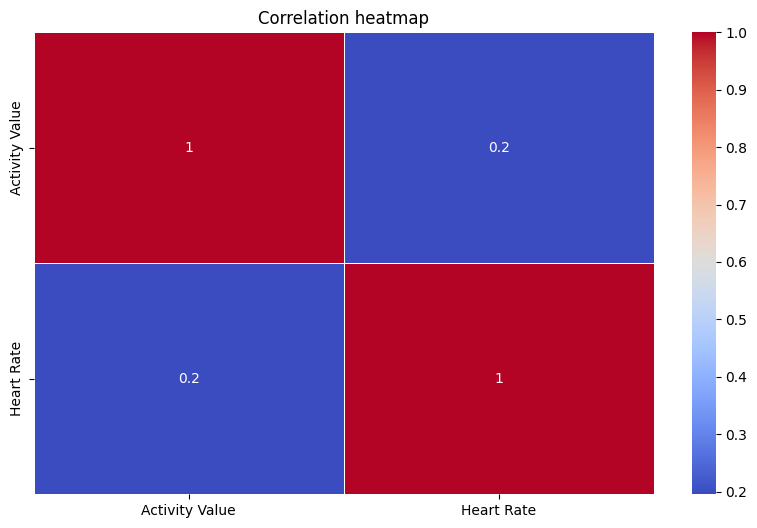

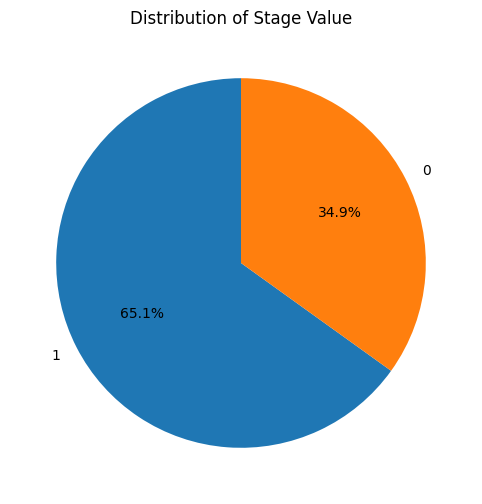

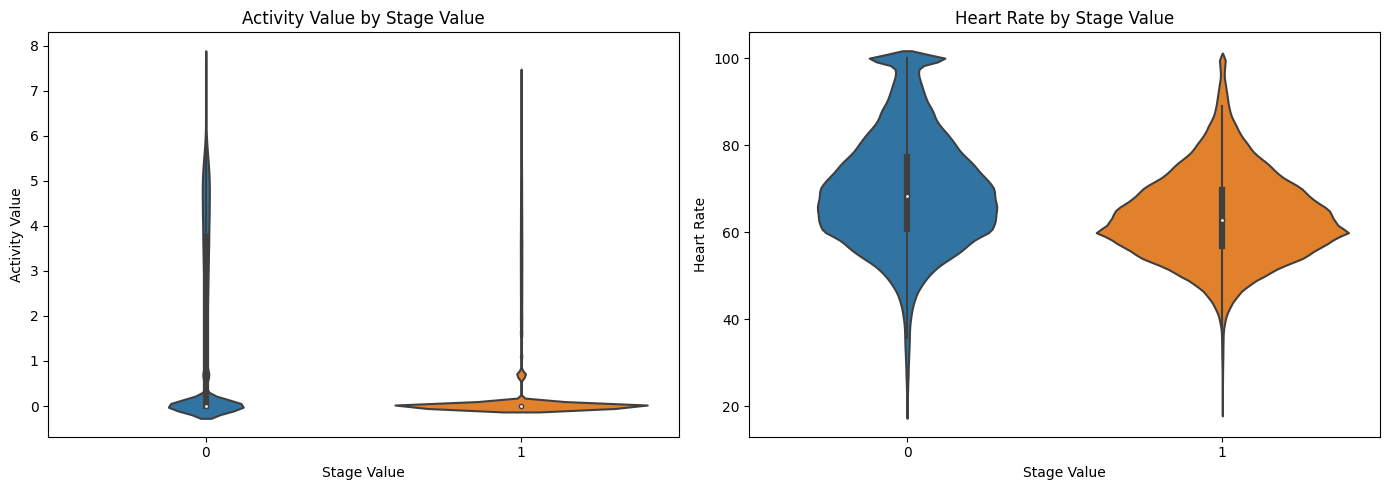

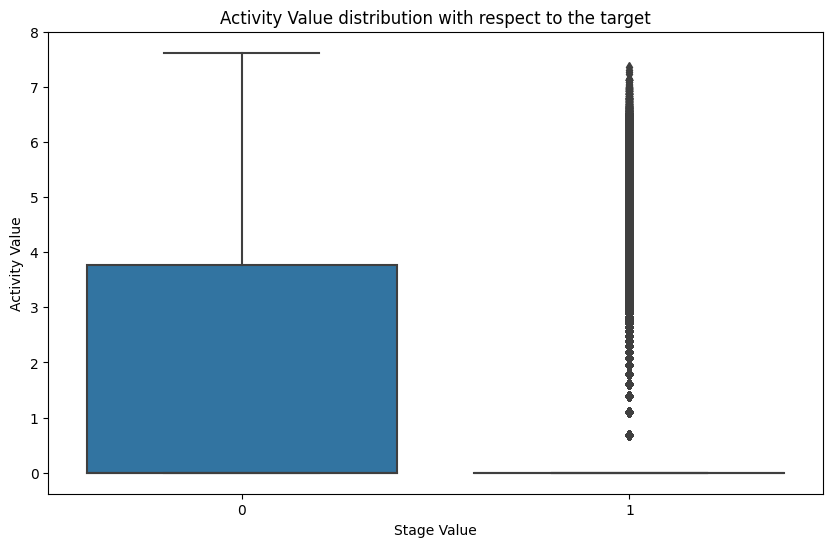

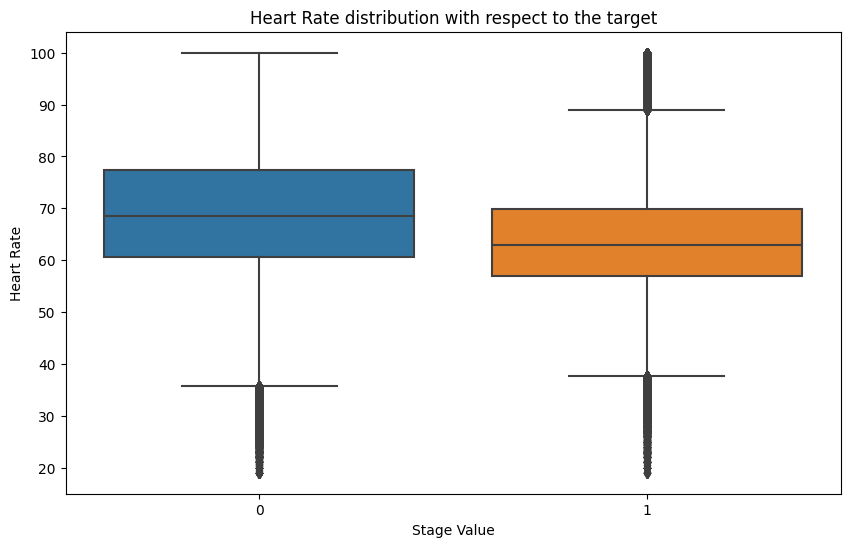

In [44]:
#Visualize the Data
final_merged_data = load_data(MERGED_DATA_FILEPATH)
final_merged_data['Activity Value'] = np.log1p(final_merged_data['Activity Value'])

X = final_merged_data.drop(['Stage Value'], axis=1)
y = final_merged_data['Stage Value']
visualize_data(X, y)


In [45]:

# Display statistics
logging.info(final_merged_data.info())

INFO:root:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175655 entries, 0 to 2175654
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Activity Value  float64
 1   Heart Rate      float64
 2   Stage Value     int64  
dtypes: float64(2), int64(1)
memory usage: 49.8 MB


In [46]:
logging.info(final_merged_data.describe())

INFO:root:       Activity Value    Heart Rate   Stage Value
count    2.175655e+06  2.175655e+06  2.175655e+06
mean     8.571510e-01  6.573082e+01  6.508605e-01
std      1.647943e+00  1.145423e+01  4.766982e-01
min      0.000000e+00  1.900053e+01  0.000000e+00
25%      0.000000e+00  5.799919e+01  0.000000e+00
50%      0.000000e+00  6.453244e+01  1.000000e+00
75%      6.931472e-01  7.233270e+01  1.000000e+00
max      7.620215e+00  1.000000e+02  1.000000e+00


In [47]:
logging.info("\nNaN Counts in Final Merged Dataset:")
logging.info(final_merged_data.isnull().sum())

INFO:root:
NaN Counts in Final Merged Dataset:
INFO:root:Activity Value    0
Heart Rate        0
Stage Value       0
dtype: int64


INFO:root:+---------------------+--------------------+-------------+-------------+---------------------+--------------------+-------------------------------------------------------------------------+
|      Classifier     |      Accuracy      | Sensitivity | Specificity | Precision (Class 1) | F1-score (Class 1) |                           Best Hyperparameters                          |
+---------------------+--------------------+-------------+-------------+---------------------+--------------------+-------------------------------------------------------------------------+
| Logistic Regression | 0.7388855310239905 |     0.92    |     0.41    |         0.74        |        0.82        |                   C=0.1, class_weight=None, penalty=l2                  |
|    Random Forest    | 0.7419719578701587 |     0.91    |     0.44    |         0.75        |        0.82        | max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100 |
|  Gradient Boosting  | 0.74233966322785

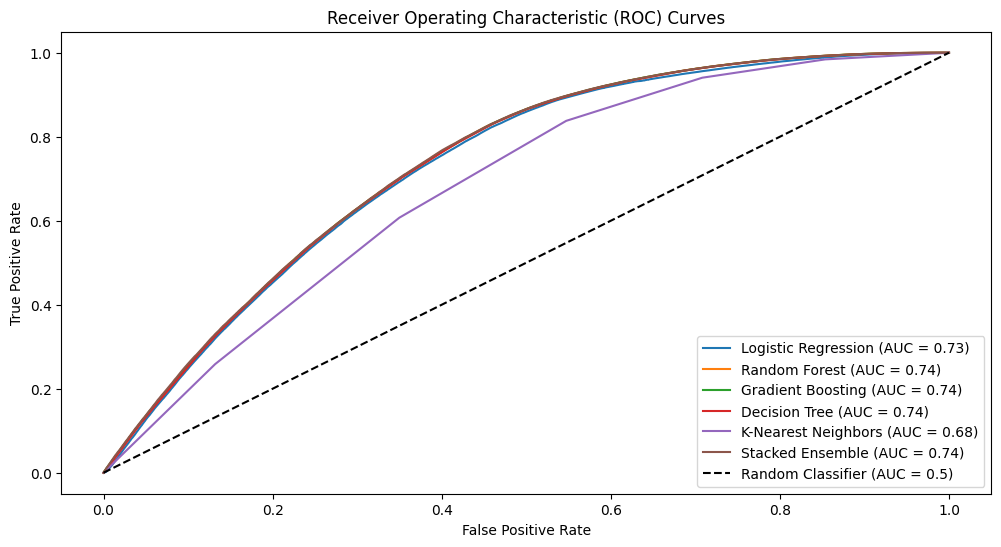

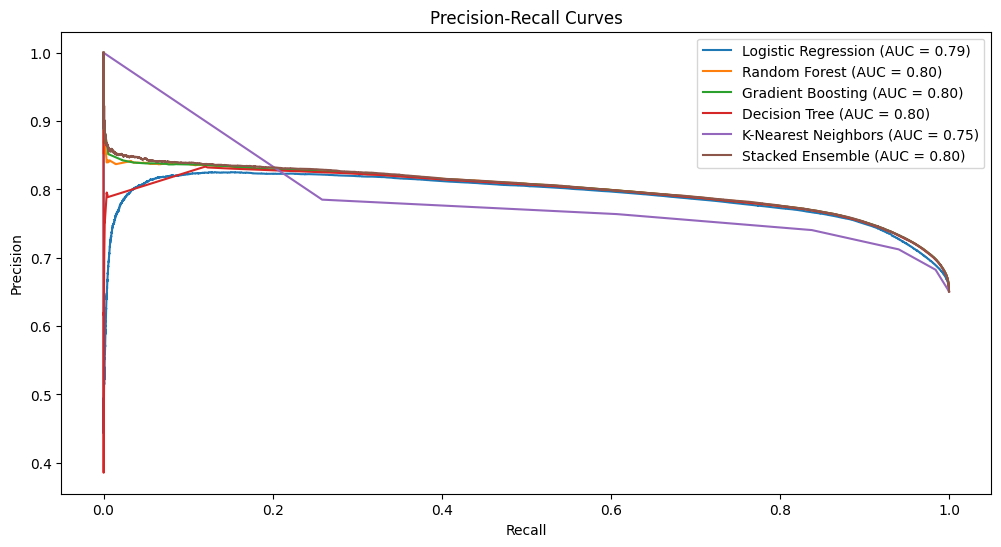

In [48]:
# Split data and train classifiers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
results = train_and_evaluate_classifiers(X_train, y_train, X_test, y_test)

table = PrettyTable(["Classifier", "Accuracy", "Sensitivity", "Specificity", "Precision (Class 1)", "F1-score (Class 1)", "Best Hyperparameters"])

for name, metrics in results.items():
    report_lines = metrics['Classification Report'].split("\n")
    sensitivity = report_lines[3].split()[2]
    specificity = report_lines[2].split()[2]
    precision_class1 = report_lines[3].split()[1]
    f1_class1 = report_lines[3].split()[3]
    hyperparams_str = metrics.get('Best Hyperparameters', 'N/A')
    table.add_row([name, metrics['Accuracy'], sensitivity, specificity, precision_class1, f1_class1, hyperparams_str])

logging.info(table)


# Plot results
plot_results(X_test, y_test, classifiers)